In [1]:
# https://ai.plainenglish.io/audio-data-music-genre-classification-8fe58cc9444e
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments
import torchaudio
import torchaudio.transforms as T
import torch
import numpy as np
import os

/Users/max/miniforge3/envs/torchaudio/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model_id = "ntu-spml/distilhubert"
model_path = 'distilhubert-finetuned-2sec_voice/checkpoint-420'
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_path, do_normalize=True, return_attention_mask=True
)

sampling_rate = feature_extractor.sampling_rate

In [3]:
sampling_rate = feature_extractor.sampling_rate
sampling_rate

16000

In [4]:
from datasets import load_dataset, Audio

dataset = load_dataset('audiofolder', data_dir='Rebetika_2sec')
dataset_whole = load_dataset('audiofolder', data_dir='Rebetika_whole')

Generating train split: 337 examples [00:00, 5937.92 examples/s]
Generating test split: 49 examples [00:00, 5518.08 examples/s]


In [5]:
# resample audio files to desired sample rate
dataset = dataset.cast_column('audio', Audio(sampling_rate=sampling_rate))
dataset_whole = dataset_whole.cast_column('audio', Audio(sampling_rate=sampling_rate))

In [6]:
max_duration = 10.0

def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

In [7]:
dataset_encoded = dataset.map(
    preprocess_function,
    remove_columns=['audio'],
    batched=True,
    batch_size=100,
    num_proc=1,
)
dataset_encoded

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 229.01 examples/s]


DatasetDict({
    train: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 337
    })
    test: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 49
    })
})

In [8]:
dataset_whole_encoded = dataset_whole.map(
    preprocess_function,
    remove_columns=['audio'],
    batched=True,
    batch_size=100,
    num_proc=1,
)
dataset_whole_encoded

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 114
    })
    test: Dataset({
        features: ['label', 'input_values', 'attention_mask'],
        num_rows: 23
    })
})

In [9]:
id2label_fn = dataset['train'].features['label'].int2str
id2label_fn(dataset['train'][50]['label'])

'Bithikotsis'

In [10]:
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(dataset_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

id2label['2']

'KaitiGkrey'

In [11]:
num_labels = len(id2label)

model = AutoModelForAudioClassification.from_pretrained(
    model_path,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)

In [12]:
dataset_encoded['train'][50]['input_values']

[0.1306966096162796,
 0.21162644028663635,
 0.1070602610707283,
 0.09797975420951843,
 0.1496877819299698,
 0.19123049080371857,
 0.14111997187137604,
 0.11628217995166779,
 0.13601769506931305,
 0.13872942328453064,
 0.0765298455953598,
 0.0367339551448822,
 0.05391448736190796,
 0.06193388253450394,
 0.012491131201386452,
 -0.04076165705919266,
 -0.0457657091319561,
 -0.030962055549025536,
 -0.04163206368684769,
 -0.0771537646651268,
 -0.09954814612865448,
 -0.10884657502174377,
 -0.1176418736577034,
 -0.13474413752555847,
 -0.13577909767627716,
 -0.11707248538732529,
 -0.10291127115488052,
 -0.11654389649629593,
 -0.13114352524280548,
 -0.11957724392414093,
 -0.08509604632854462,
 -0.05510722100734711,
 -0.03850328549742699,
 -0.033774565905332565,
 -0.03917115181684494,
 -0.04677901789546013,
 -0.03631235286593437,
 -0.002243046648800373,
 0.034071505069732666,
 0.04710903391242027,
 0.043827831745147705,
 0.03473367914557457,
 0.021839968860149384,
 0.021657705307006836,
 0.053460

In [13]:
t = torch.FloatTensor( dataset_encoded['train'][50]['input_values'] )
tt = t.view(1, t.shape[0])
print(tt.shape)

torch.Size([1, 32000])


In [14]:
model.eval()

HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): HubertEncoder(
      (pos_conv_embed): HubertPositionalConvEmbedding(

In [15]:
# run accuracy on test set
test_results = []
test_accuracy = []
for datapoint in dataset_encoded['test']:
    t = torch.FloatTensor( datapoint['input_values'] )
    c = model( t.view(1, t.shape[0]) )['logits'].argmax()
    test_results.append( c )
    test_accuracy.append( c == datapoint['label'] )
# test_results = np.array( test_arrays )
# test_prediction = model(tt)
# print(test_prediction['logits'].argmax())

In [16]:
print('test_accuracy: ', np.sum(test_accuracy)/len(test_accuracy))

test_accuracy:  0.7959183673469388


In [17]:
# run whole accuracy
# run accuracy on test set
whole_results = []
whole_accuracy = []
for train_test in ['train', 'test']:
    for datapoint in dataset_whole_encoded[train_test]:
        t = torch.FloatTensor( datapoint['input_values'] )
        c = model( t.view(1, t.shape[0]) )['logits'].argmax()
        whole_results.append( c )
        whole_accuracy.append( c == datapoint['label'] )

In [18]:
print('whole_accuracy: ', np.sum(whole_accuracy)/len(whole_accuracy))

whole_accuracy:  0.9416058394160584


In [19]:
h = model.hubert( tt ).last_hidden_state
print(h.shape) # (batch_size, sequence_length, hidden_size)
p = model.projector( h )
print(p.shape)
f = p.mean(axis=1)
print(f.shape)
fp = f.detach().numpy()
print(fp.shape)

torch.Size([1, 99, 768])
torch.Size([1, 99, 256])
torch.Size([1, 256])
(1, 256)


In [20]:
def extract_hubert(d):
    h = model.hubert( d ).last_hidden_state
    p = model.projector( h )
    f = p.mean(axis=1)
    return f.detach().numpy()

In [21]:
values = []
ids = {}
idxs = {}
i = 0
for train_test in ['train', 'test']:
    ids[train_test] = []
    idxs[train_test] = []
    for datapoint in dataset_encoded[train_test]:
        t = torch.FloatTensor( datapoint['input_values'] )
        values.append( extract_hubert( t.view(1, t.shape[0]) ) )
        ids[train_test].append( datapoint['label'] )
        idxs[train_test].append( i )
        i += 1

In [22]:
values_np = np.array(values).squeeze()

In [23]:
print(values_np.shape)

(386, 256)


In [24]:
from sklearn.manifold import TSNE

In [25]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(values_np)

In [26]:
print(X_embedded.shape)

(386, 2)


In [27]:
import matplotlib.pyplot as plt

In [28]:
labels = []
for i in ids['train']:
    labels.append( id2label[str(i)] )

[]

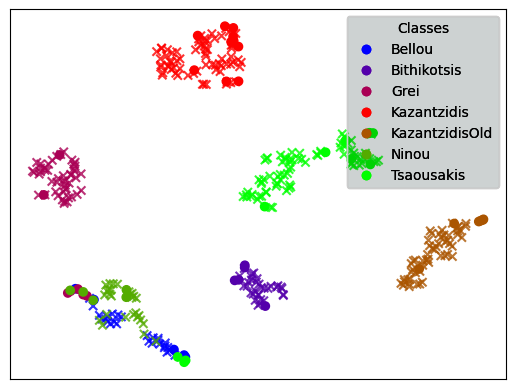

In [31]:
fig, ax = plt.subplots()

scatter = ax.scatter(X_embedded[idxs['train'],0], X_embedded[idxs['train'],1], marker='x', c=ids['train'], cmap='brg', alpha=0.8)
scatter = ax.scatter(X_embedded[idxs['test'],0], X_embedded[idxs['test'],1], marker='o', c=ids['test'], cmap='brg')
legends = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
legends.get_frame().set_alpha(None)
legends.get_frame().set_facecolor((0, 0.1, 0.1, 0.1))
for i,t in enumerate(legends.get_texts()):
    t.set_text( id2label[str(i)].replace('KaitiGkrey', 'Grei') )
ax.add_artist(legends)
ax.set_xticks([])
ax.set_yticks([])

In [32]:
os.makedirs('figs', exist_ok=True)
fig.savefig('figs/tsne_2sec.png', dpi=300)